<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [5]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC(dual=True)

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.8700000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

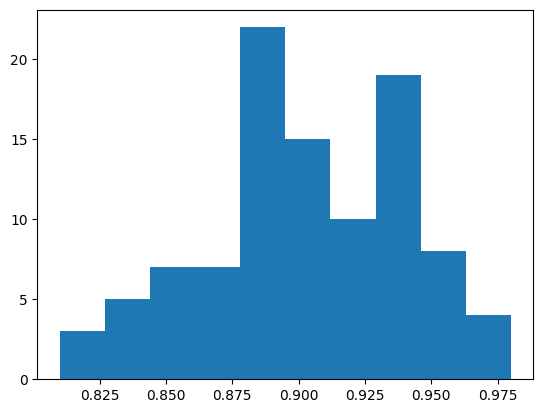

In [7]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC(dual=True)

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

### Explanation of fix
We can notice that we are generating a number of features much larger than the dataset size by a factor of 10. Under such generation conditions, even generating features randomly, we can get a randomly high correlation with the target feature. At the same time, by removing all other features and leaving only the best ones, we actually leave only randomly well-generated features, which leads to this result. We can correct this situation if we remove the selection of features and use all of them. Then the random strong correlation will be compensated by the remaining features. It would also help if we generated a data set larger than the number of features.

In [38]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Simple classification model
model = LinearSVC(dual=True)

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.5


## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [14]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2023-11-03 18:23:40--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58,89K  --.-KB/s    in 0,04s   

2023-11-03 18:23:41 (1,30 MB/s) - ‘train.csv’ saved [60302/60302]



In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')

Base model reach 0.82 accuracy.

In [32]:
def feature_selection_and_preprocessing(dataset: pd.DataFrame):
    features = dataset.copy()
    features = features.drop(
        ["Name", "Ticket", "Cabin", "SibSp", 'Age'], axis=1)
    features = features.replace({'Sex': {'male': 0, 'female': 1}})
    features = features.replace({'Embarked': {'S': 0, 'C': 1, 'Q': 2}})
    features['Embarked'] = features['Embarked'].fillna(
        features['Embarked'].median())
    features = (features-features.mean())/features.std()
    return features


parameters = {
    'n_neighbors': list(range(1, 40)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
data_train = data.iloc[:-100]

model = KNeighborsClassifier()
clf = GridSearchCV(
    model,
    parameters,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1)
clf.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ), 
    data_train['Survived']
)
model = clf.best_estimator_
print(clf.best_params_)
print("CV accuracy: ", round(clf.best_score_, 2))


# Validation code (do not touch)
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)
print("Test accuracy of model with better parameters:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Fitting 5 folds for each of 156 candidates, totalling 780 fits
{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}
CV accuracy:  0.81
Test accuracy of model with better parameters: 0.82


Best combinations of parameters:
- Metric: manhattan
- weights: distance
- n_neighbors: 16

Accuracies for base model and model with parameters tunning are same.